In [1]:
import jax
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from numpyro.infer import MCMC, NUTS, Predictive
import jax.numpy as jnp
import arviz as az

numpyro.set_host_device_count(4)

In [2]:
df = pd.DataFrame(
    {
        "Value": [0, 1, 2, 3, 4, 5, 6, 7],
        "Frequency": [18, 19, 22, np.nan, np.nan, 19, 20, 22],
    }
)

In [3]:
df

,Value,Frequency
0,0,18.0
1,1,19.0
2,2,22.0
3,3,NaN
4,4,NaN
5,5,19.0
6,6,20.0
7,7,22.0


In [4]:
samples = dist.Dirichlet(jnp.ones(8)*56).sample(jax.random.PRNGKey(0), sample_shape=(1000,))

In [5]:
((samples.max(axis=1) / samples.min(axis=1)) > 2).mean()

DeviceArray(0.01, dtype=float32)

In [6]:
def model(value, frequency):
    n_missing = int(np.isnan(df['Frequency']).sum())
    idx_missing = np.where(np.isnan(df['Frequency']))[0]
    n_vals = len(np.unique(value))
    
    n_spins = numpyro.sample('n_spins', dist.Normal(160, 20))
    probs = numpyro.sample('probs', dist.Dirichlet(jnp.ones(n_vals)*56))
    sigma = numpyro.sample('sigma', dist.HalfNormal(5))
    
    rate = numpyro.deterministic('rate', probs * n_spins)
    frequency_impute = numpyro.sample('frequency_impute', dist.Normal(20, 5).expand([n_missing]).mask(False))
    frequency_imputed = jax.ops.index_update(frequency, idx_missing, frequency_impute)
    numpyro.sample('frequency', dist.Poisson(rate[value]), obs=frequency_imputed)

In [7]:
mcmc = MCMC(
    NUTS(model, target_accept_prob=.9),
    num_chains=4,
    num_samples=1000,
    num_warmup=1000,
)
mcmc.run(
    jax.random.PRNGKey(0),
    value=df['Value'].to_numpy(),
    frequency=df['Frequency'].to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
frequency_impute[0]     20.09      5.52     19.70     10.74     28.45   2961.27      1.00
frequency_impute[1]     20.15      5.48     19.81     11.22     29.00   3089.66      1.00
            n_spins    160.77     12.07    160.42    141.51    180.78   3246.51      1.00
           probs[0]      0.12      0.01      0.12      0.10      0.14   4263.82      1.00
           probs[1]      0.12      0.01      0.12      0.10      0.15   4613.60      1.00
           probs[2]      0.13      0.01      0.13      0.11      0.15   4068.24      1.00
           probs[3]      0.13      0.02      0.12      0.10      0.15   3381.19      1.00
           probs[4]      0.13      0.02      0.12      0.10      0.15   3462.87      1.00
           probs[5]      0.12      0.01      0.12      0.10      0.14   4129.95      1.00
           probs[6]      0.13      0.01      0.12      0.10      0.15   4117.11      1.00
         

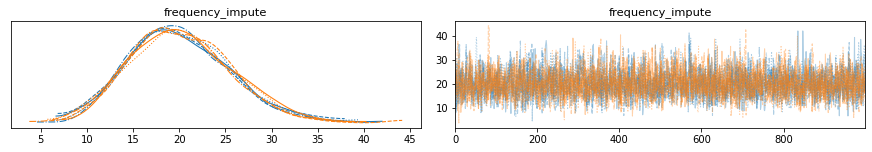

In [9]:
az.plot_trace(az.from_numpyro(mcmc), var_names=['frequency_impute']);